In [1]:
from segment_image import *

In [2]:
def draw_hough_lines(lines, shape, line_thickness):
    lines_img = np.zeros(shape)
    for l in lines:
        x1 = l[0][0]
        y1 = l[0][1]
        x2 = l[1][0]
        y2 = l[1][1]
        #print(l)
        #print(x1, y1, x2, y2)
        cv2.line(lines_img, (x1,y1), (x2,y2), (255,255,255), line_thickness)

    return lines_img

In [3]:
def potential_staff_lines(note_img_thresh, staff_thickness):
    DEG_TO_RAD = np.pi/180
    width = note_img_thresh.shape[1]

    # Hough to get potential staff lines
    line_length = int(width/4)
    lines = probabilistic_hough_line(note_img_thresh, threshold=10, line_length=line_length, line_gap=3, theta=np.arange(80*DEG_TO_RAD, 100*DEG_TO_RAD, 1*DEG_TO_RAD), seed=40)
    lines_img_before_filteration = draw_hough_lines(lines, note_img_thresh.shape, 1)
    lines_img_before_filteration = cv2.dilate(lines_img_before_filteration, np.ones((1, 11)))

    # Get widest 5 contours/lines
    lines_img = np.copy(lines_img_before_filteration)
    image, contours, hierarchy = cv2.findContours(lines_img_before_filteration.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours_bounding_rectangles = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        #print(x, y, w, h)
        contours_bounding_rectangles.append([c, [x, y, w, h]])

    contours_bounding_rectangles_sorted = sorted(contours_bounding_rectangles, key = lambda x: x[1][2], reverse=True) # sort by width
    contours_widest_5 = []
    j = 5 if len(contours_bounding_rectangles_sorted) >= 5 else len(contours_bounding_rectangles_sorted)
    for i in range(j):
        contours_widest_5.append(contours_bounding_rectangles_sorted[i][0])

    # Draw widest 5 contours/lines
    lines_img = np.zeros(note_img_thresh.shape, dtype=np.uint8)
    lines_img = rgb2gray(cv2.drawContours(gray2rgb(lines_img), contours_widest_5, -1, (255,255,255), 1))
    k = 3
    lines_img = my_close(lines_img, np.ones((k*staff_thickness, k*staff_thickness)))

    # my_show_images([lines_img])

    return lines_img

In [32]:
def remove_staff_lines(note_img_gray):
    # Otsu's thresholding
    ret, note_img_thresh = cv2.threshold(note_img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # distance_between_staves, staff_thickness
    distance_between_staves, staff_thickness = get_distance_between_staves_and_staff_thickness(note_img_thresh)

    note_img_thresh = ~note_img_thresh

    # Potential staff lines
    lines_img = potential_staff_lines(note_img_thresh, staff_thickness)
    lines_img_flattened = (lines_img > 0.5).T.flatten()
    
    # Iterate over each column to remove any "run of white pixels" with a length of "m*staff_thickness"
    # But it must be a part from a potentail line to confirm removing (potential lines calculated above)
    note_img_thresh_flattened = (note_img_thresh).T.flatten()
    image, contours, hierarchy = cv2.findContours((note_img_thresh_flattened).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        if c.shape == (2, 1, 2):
            p1 = c[1][0][1]
            p0 = c[0][0][1]
            m = 1.55
            if p1 - p0 <= staff_thickness*m:
                #print(c)
                staff_pixel_percentage = lines_img_flattened[p0:p1+1].sum() / len(lines_img_flattened[p0:p1+1])
                if staff_pixel_percentage > 0.35:
                    note_img_thresh_flattened[p0:p1+1] = 0
        elif c.shape == (1, 1, 2):
            #print(c)
            p0 = c[0][0][1]
            staff_pixel_percentage = lines_img_flattened[p0:p0+1].sum() / len(lines_img_flattened[p0:p0+1])
            if staff_pixel_percentage > 0.35:
                note_img_thresh_flattened[p0:p0+1] = 0


    staff_lines_removed = note_img_thresh_flattened.reshape(note_img_thresh.T.shape).T

    return staff_lines_removed

In [24]:
def getNotes(original_img, img_thresh):

    #ori_img = io.imread(pathImage)

    width= original_img.shape[1]
    height = original_img.shape[0]

    #img_thresh = ori_img
    #show_images([img_thresh],["thresh"])

    hist = []

    # get Concentration Histogram
    for x in range(width):
        hist.append(sum(img_thresh[0:height,x] == 0))

    # find thr for detecting character
    occurence_count = Counter(hist)
    thr_character = occurence_count.most_common(1)[0][0] * 1.25



    #convert list of hist to numpy array as uint8 for  using in countours
    a = np.zeros(img_thresh.shape)
    arr = np.array(hist)
    a = a < ((arr > thr_character)*255)
    a = a.astype('uint8')

    # using a that represnts hist list in countours
    contours, hierarchy = cv.findContours(a, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[-2:]
    listOfImages = []
   
    for contour in contours:

        x, y, w, h = cv.boundingRect(contour)
       
        out = original_img[y:y+h,x:x+w]
        listOfImages.append(out)
        
    return listOfImages    

In [97]:
def add_padding(img_gray, ww, hh, color):
    ht, wd = img_gray.shape[:2]

    # create new image of desired size and color (blue) for padding
    result = np.full((hh, ww), color, dtype=np.uint8)

    # compute center offset
    xx = (ww - wd) // 2
    yy = (hh - ht) // 2

    # copy img image into center of result image
    result[yy:yy+ht, xx:xx+wd] = img_gray

    return result

In [94]:
def zoom_in(staff_lines_removed):
    notes = []
    notes_contours = []


    staff_lines_removed = np.ascontiguousarray(staff_lines_removed)
    test_copy = cv2.dilate(staff_lines_removed, np.ones((5, 5)))
    test_copy = staff_lines_removed

    image, contours, hierarchy = cv2.findContours(test_copy,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #contours_drawn = gray2rgb(np.copy(test_copy))
    contours_sorted_by_area = sorted(contours, key=cv2.contourArea, reverse=True)
    
    max_area_contour = contours_sorted_by_area[0]
    x, y, w, h = cv2.boundingRect(max_area_contour)
    a0 = w*h

    
    zoomed_in_biggest = np.copy(staff_lines_removed[y:y+h, x:x+w])
    notes.append(zoomed_in_biggest)
    notes_contours.append(max_area_contour)

    if len(contours_sorted_by_area) > 1:
        second_max_area_contour = contours_sorted_by_area[1]
        x1, y1, w1, h1 = cv2.boundingRect(second_max_area_contour)
        a1 = w1*h1
        
        if a1 / a0 > 0.5:
            zoomed_in_second_biggest = np.copy(staff_lines_removed[y1:y1+h1, x1:x1+w1])
            notes.append(zoomed_in_second_biggest)
            notes_contours.append(second_max_area_contour)

    return notes, notes_contours

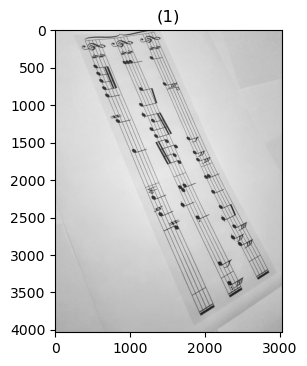

In [6]:
img = my_imread_gray('18.jpg')
my_show_images([img], dpi=100)

In [7]:
gray_lines, binary_lines = get_lines(img)

In [18]:
cv2.imwrite('binary_line.png', binary_lines[0])

True

# Separate lines

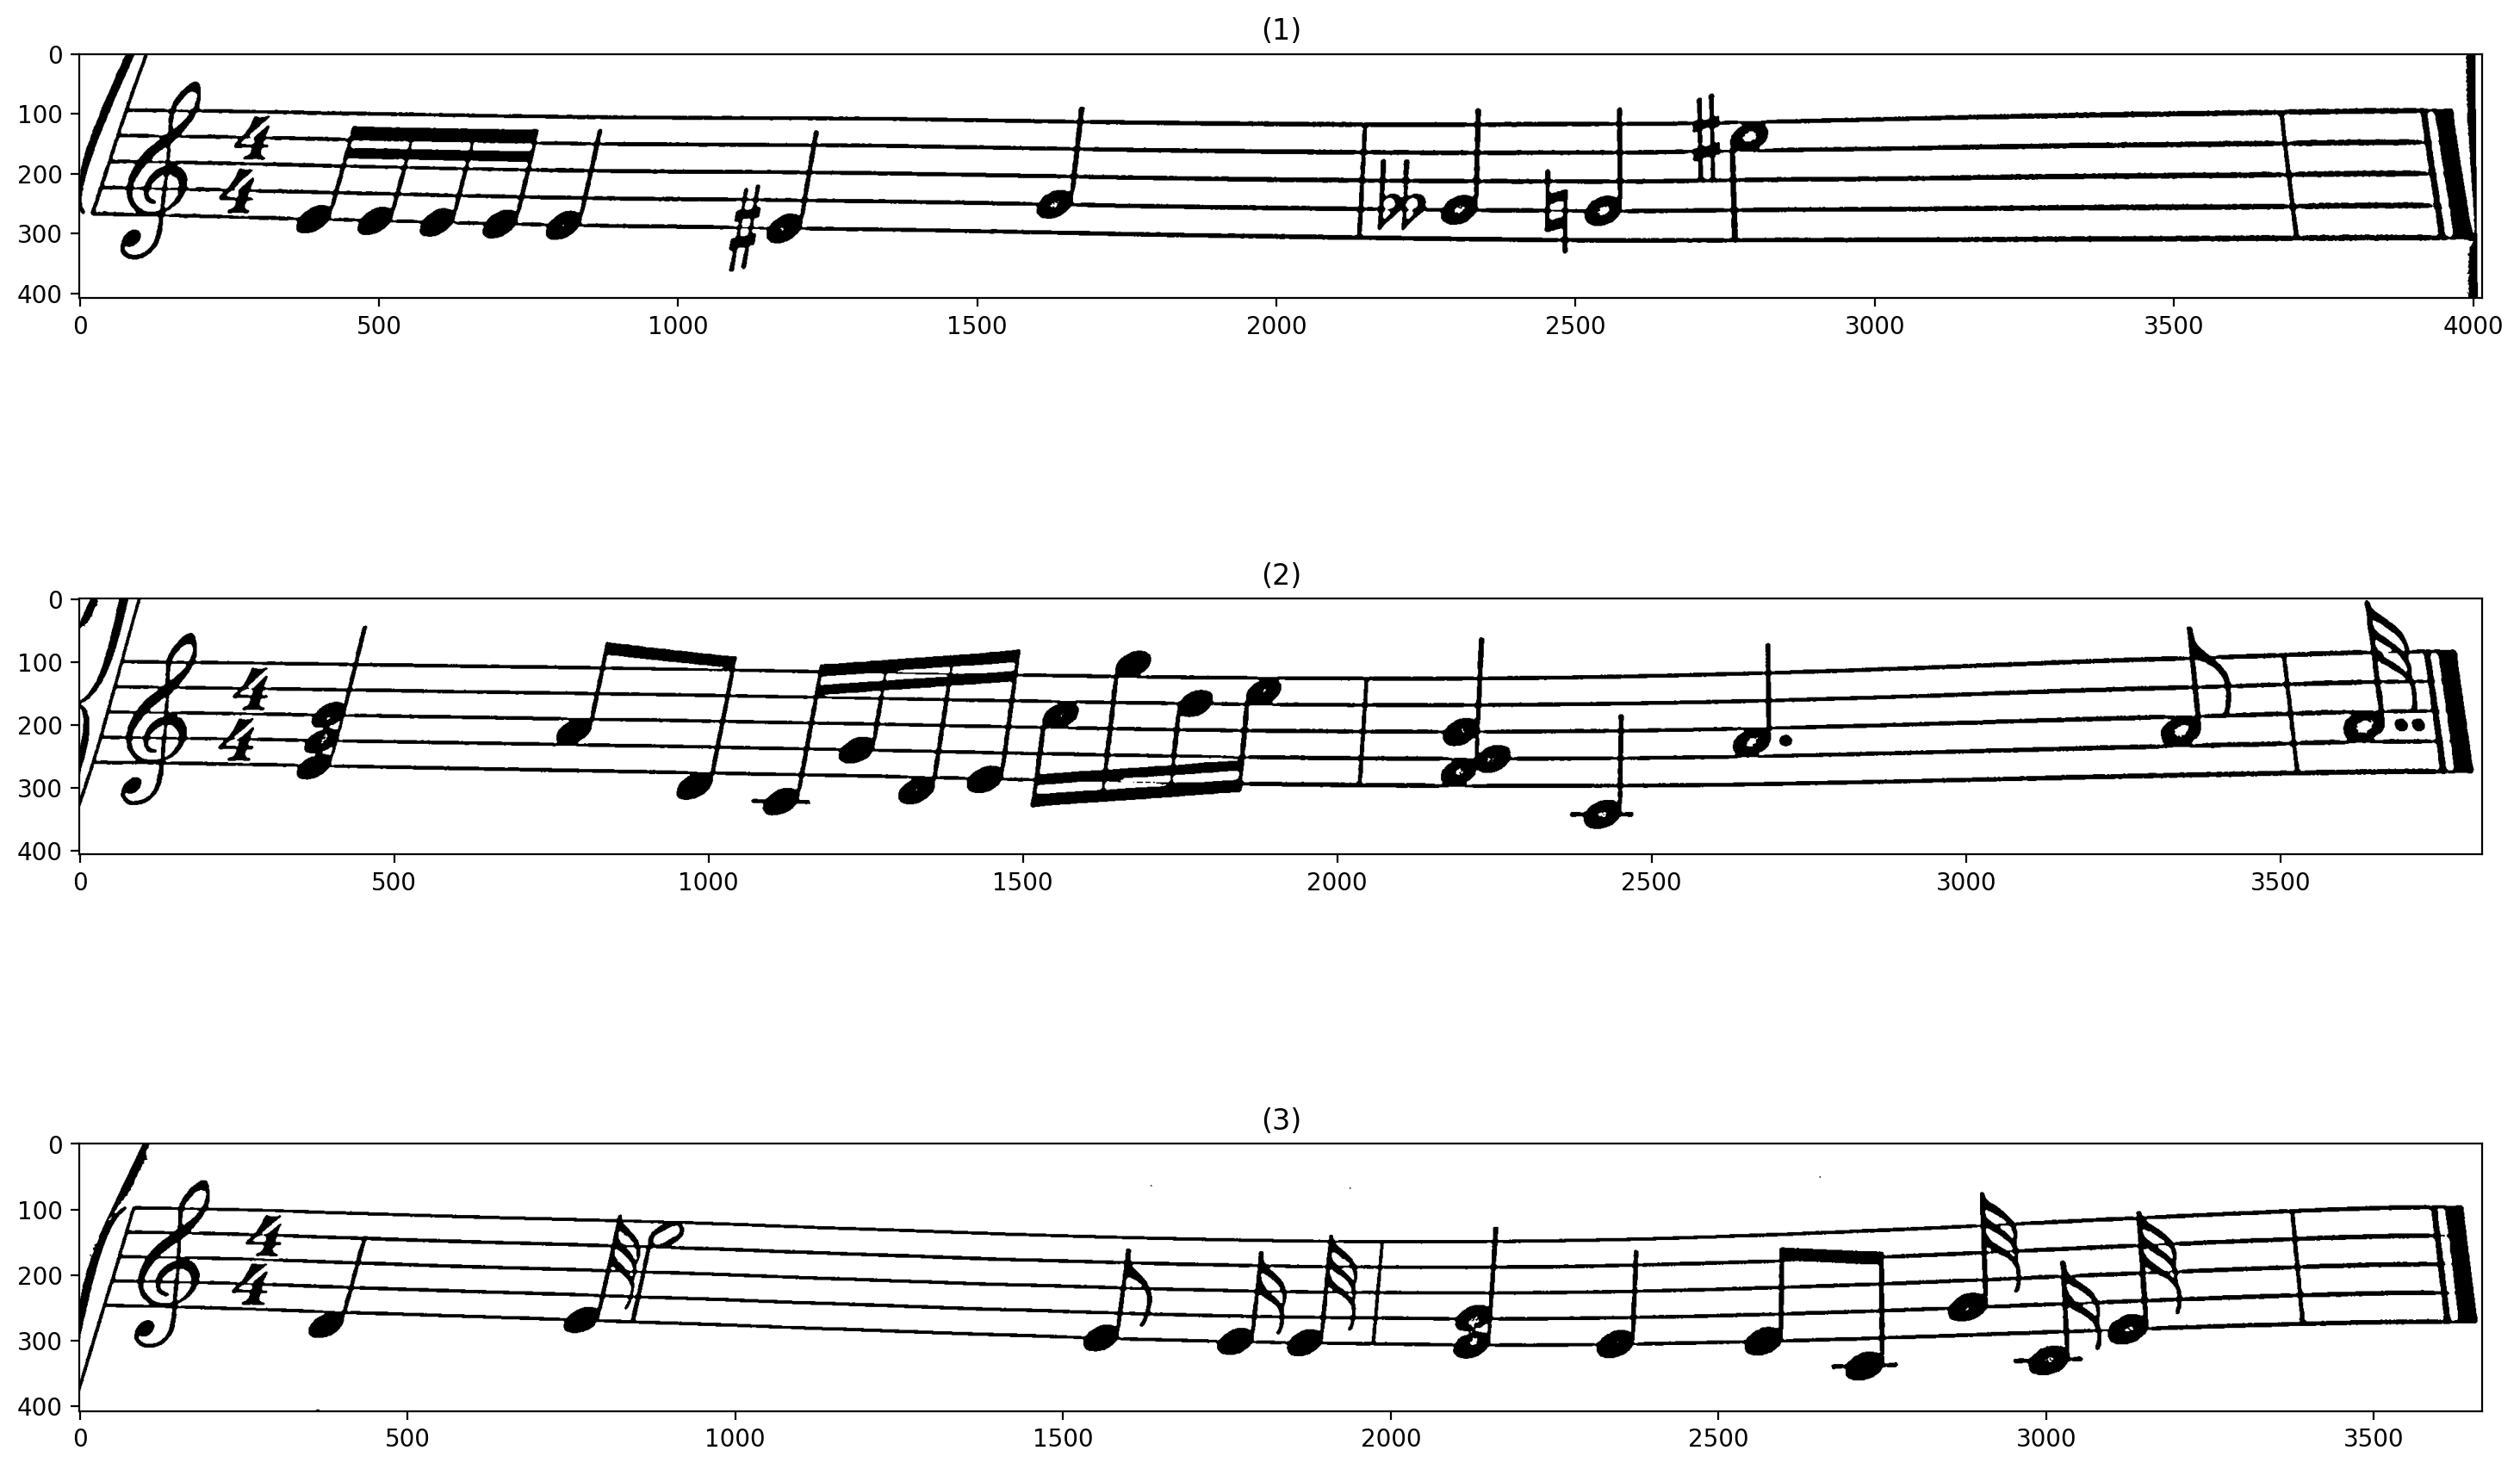

In [15]:
my_show_images(binary_lines, dpi=200)

# Shubra's potential_lines_of_notes 

In [49]:
potential_lines_of_notes = []
for i in range(len(gray_lines)):
    potential_lines_of_notes.append(getNotes(gray_lines[i] ,binary_lines[i]))

# Removing staff lines

In [50]:
list_of_notes = []
for i, potential_lines_of_notes in enumerate(potential_lines_of_notes):
    list_of_notes.append([])
    for note in potential_lines_of_notes:
        if note.shape[1] >= 30:
            staff_lines_removed = remove_staff_lines(note)
            if (staff_lines_removed > 128).any():
                list_of_notes[i].append(staff_lines_removed)

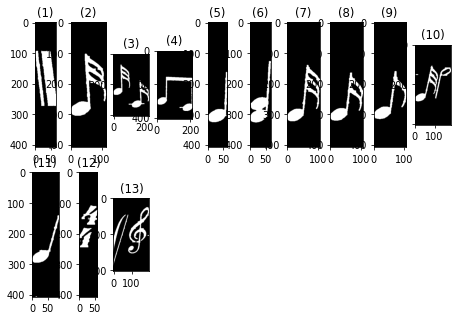

In [57]:
my_show_images(list_of_notes[2], dpi=70, row_max=10)

# Zoom in

In [98]:
list_of_notes_classification_ready = []
list_of_notes_classification_ready_contours = []

for i, line_of_notes in enumerate(list_of_notes):
    list_of_notes_classification_ready.append([])
    list_of_notes_classification_ready_contours.append([])

    for note in line_of_notes:
        notes, notes_contours = zoom_in(note)
        for n, c in zip(notes, notes_contours):
            n = add_padding(n, ww=int(n.shape[1]*2.5), hh=int(n.shape[0]*1.5), color=0)
            list_of_notes_classification_ready[i].append(n)
            list_of_notes_classification_ready_contours[i].append(c)

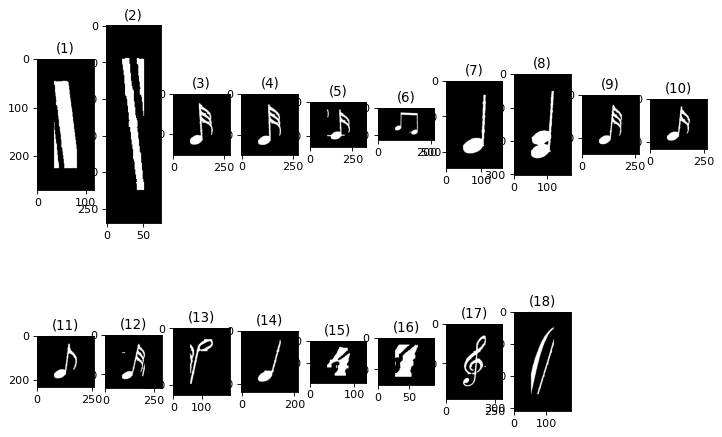

In [99]:
my_show_images(list_of_notes_classification_ready[2], dpi=80, row_max=10)